# Importing some packages

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Model training

Creating higher-order function for a training step

In [5]:
def make_train_step_fn(model, optimizer, lossfn):

    def perform_train_step(x, y):

        model.train()

        y_hat = model(x)

        loss = lossfn(y_hat, y)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        return loss.item()
    
    return perform_train_step

Running data preparation

In [13]:
N = 100
ERROR_SCALE = 0.1
TRUE_B = 1
TRUE_W = 2

np.random.seed(42)

X = np.random.rand(N, 1)
error = ERROR_SCALE * np.random.randn(N, 1)
y = TRUE_B + TRUE_W * X + error

idx = np.arange(N)
np.random.shuffle(idx)

train_idx = idx[:int(N*.8)]
val_idx = idx[int(N*.8):]

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train_tensor = torch.as_tensor(X_train).float().to(device)
X_val_tensor = torch.as_tensor(X_val).float().to(device)

y_train_tensor = torch.as_tensor(y_train).float().to(device)
y_val_tensor = torch.as_tensor(y_val).float().to(device)

In [7]:
%run -i data_preparation/v0.py

Creating the model configuration

In [17]:
%%writefile model_configuration/v1.py

lr = 0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 1)).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

lossfn = nn.MSELoss(reduction="mean")

train_step_fn = make_train_step_fn(model, optimizer, lossfn)

Overwriting model_configuration/v1.py


In [18]:
%run -i model_configuration/v1.py

In [19]:
train_step_fn

<function __main__.make_train_step_fn.<locals>.perform_train_step(x, y)>

Creating model training

In [20]:
%%writefile model_training/v1.py

epochs = 1000

losses = []

for _ in range(epochs):

    loss = train_step_fn(X_train_tensor, y_train_tensor)

    losses.append(loss)

Overwriting model_training/v1.py


In [21]:
%run -i model_training/v1.py

In [22]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')),
             ('0.bias', tensor([1.0235], device='cuda:0'))])

# Datasets

In [23]:
class CustomDS(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    def __len__(self):
        return len(self.x)

In [25]:
X_train_tensor = torch.as_tensor(X_train).float()
X_val_tensor = torch.as_tensor(X_val).float()

y_train_tensor = torch.as_tensor(y_train).float()
y_val_tensor = torch.as_tensor(y_val).float()

train_data = CustomDS(X_train_tensor, y_train_tensor)
train_data[0]

(tensor([0.7713]), tensor([2.4745]))

In [26]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_data[0]

(tensor([0.7713]), tensor([2.4745]))

# DataLoader

In [27]:
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

next(iter(train_loader))

[tensor([[0.2809],
         [0.3253],
         [0.1560],
         [0.5924],
         [0.0651],
         [0.8872],
         [0.4938],
         [0.0055],
         [0.1409],
         [0.0885],
         [0.1849],
         [0.7290],
         [0.8662],
         [0.3117],
         [0.6842],
         [0.1987]]),
 tensor([[1.5846],
         [1.8057],
         [1.2901],
         [2.1687],
         [1.1559],
         [2.8708],
         [1.9060],
         [1.0632],
         [1.1211],
         [1.0708],
         [1.5888],
         [2.4927],
         [2.6805],
         [1.7637],
         [2.3492],
         [1.2654]])]

In [29]:
%%writefile data_preparation/v1.py

X_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

train_data = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

Overwriting data_preparation/v1.py


In [30]:
%run -i data_preparation/v1.py

Adding the data loader to the training process

In [31]:
%run -i model_configuration/v1.py

In [33]:
%%writefile model_training/v2.py

epochs = 1000

losses = []

for _ in range(epochs):

    mini_batch_losses = []

    for x_batch, y_batch in train_loader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_losses.append(train_step_fn(x_batch, y_batch))

    loss = np.mean(mini_batch_losses)

    losses.append(loss)

Writing model_training/v2.py


In [34]:
%run -i model_training/v2.py

Creating a function to get a mini batch loss

In [35]:
def get_minibatch_loss(device, data_loader, step_fn):

    mini_batch_losses = []

    for x_batch, y_batch in data_loader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_losses.append(step_fn(x_batch, y_batch))

    loss = np.mean(mini_batch_losses)
    
    return loss

In [36]:
%%writefile model_training/v3.py

epochs = 1000

losses = []

for _ in range(epochs):

    loss = get_minibatch_loss(device, train_loader, train_step_fn)

    losses.append(loss)

Writing model_training/v3.py


In [37]:
%run -i model_training/v3.py

In [38]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9707]], device='cuda:0')),
             ('0.bias', tensor([1.0268], device='cuda:0'))])

# Splitting data

In [39]:
%%writefile data_preparation/v2.py

X_tensor = torch.as_tensor(X).float()
y_tensor = torch.as_tensor(y).float()

train_ratio = 0.8

dataset = TensorDataset(X_tensor, y_tensor)

n_total = len(dataset)

n_train = int(n_total * train_ratio)

n_valid = n_total - n_train

train_data, valid_data = random_split(dataset, [n_train, n_valid])

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

valid_loader = DataLoader(dataset=valid_data, batch_size=16)

Writing data_preparation/v2.py


In [40]:
%run -i data_preparation/v2.py

# Evaluation

In [41]:
def make_val_step_fn(model, lossfn):

    def perform_val_step(x, y):

        model.eval()

        y_hat = model(x)

        loss = lossfn(y_hat, y)

        return loss.item()
    
    return perform_val_step

In [42]:
%%writefile model_configuration/v2.py

lr = 0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 1)).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

lossfn = nn.MSELoss(reduction='mean')

train_step_fn = make_train_step_fn(model, optimizer, lossfn)

val_step_fn = make_val_step_fn(model, lossfn)

Writing model_configuration/v2.py


In [43]:
%run -i model_configuration/v2.py

In [44]:
%%writefile model_training/v4.py

epochs = 1000

losses = []

val_losses = []

for _ in range(epochs):

    loss = get_minibatch_loss(device, train_loader, train_step_fn)

    losses.append(loss)

    with torch.no_grad():
        
        val_loss = get_minibatch_loss(device, valid_loader, val_step_fn)

        val_losses.append(val_loss)

Writing model_training/v4.py


In [45]:
%run -i model_training/v4.py

Plotting the losses

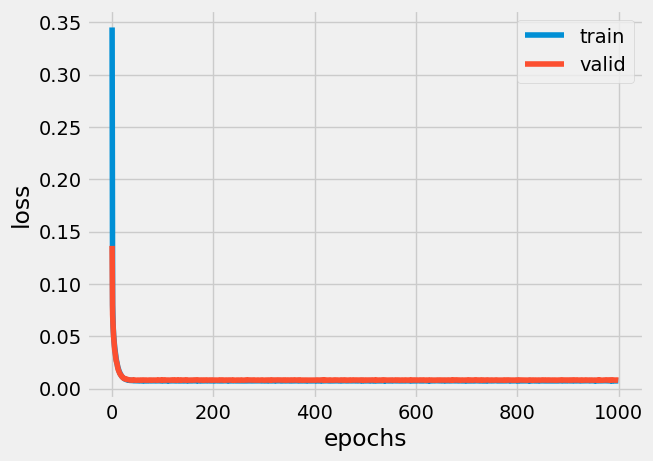

In [49]:
plt.plot(np.arange(len(losses)), losses, label='train')
plt.plot(np.arange(len(val_losses)), val_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim((0, 0.15))
plt.legend()
plt.show()

# TensorBoard

In [50]:
%load_ext tensorboard

In [52]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 31660), started 0:01:39 ago. (Use '!kill 31660' to kill it.)

Creating SummaryWriter

In [53]:
writer = SummaryWriter('runs/test')

In [54]:
dummy_x, dummy_y = next(iter(train_loader))

writer.add_graph(model, dummy_x.to(device))

In [55]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 31660), started 0:10:14 ago. (Use '!kill 31660' to kill it.)

In [58]:
writer.add_scalars(
    main_tag='loss',
    tag_scalar_dict={'training': loss, 'validation': val_loss},
    global_step=999
)

In [59]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 31660), started 0:18:46 ago. (Use '!kill 31660' to kill it.)

Creating a model configuration with SummaryWriter

In [60]:
%%writefile model_configuration/v3.py

lr = 0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 1)).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

lossfn = nn.MSELoss(reduction='mean')

train_step_fn = make_train_step_fn(model, optimizer, lossfn)

val_step_fn = make_val_step_fn(model, lossfn)

writer = SummaryWriter('runs/simple_lr')

dummy_x, dummy_y = next(iter(train_loader))

writer.add_graph(model, dummy_x.to(device))

Writing model_configuration/v3.py


In [61]:
%run -i model_configuration/v3.py

<Figure size 640x480 with 0 Axes>